In [95]:
import numpy as np

import matplotlib.pyplot as plt
import glob

from numba import njit, vectorize, float32

from typing import Callable, Optional

import hoomd
import hoomd.forward_flux.forward_flux as ffs
import gsd.hoomd

from matplotlib import cm, colors

import sys

In [96]:
sys.path.insert(0, "/home/ian/Projects/work/monk/src")
sys.path

['/home/ian/Projects/work/monk/src',
 '/home/ian/Projects/work/monk/src',
 '/home/ian/Projects/work/monk/src',
 '/home/ian/Projects/work/monk/src',
 '/home/ian/Projects/work/monk/src',
 '/home/ian/Projects/work/monk/src',
 '/home/ian/Projects/work/monk/experiments/forward-flux',
 '/home/ian/Projects/work/monk/src',
 '/home/ian/Projects/work/monk/experiments/forward-flux',
 '/home/ian/Projects/work/monk/.venv/lib/python38.zip',
 '/home/ian/Projects/work/monk/.venv/lib/python3.8',
 '/home/ian/Projects/work/monk/.venv/lib/python3.8/lib-dynload',
 '',
 '/home/ian/Projects/work/monk/.venv/lib/python3.8/site-packages']

In [97]:
from monk import nb
from monk import prep
from monk import pair
import freud
import ex_render

In [98]:
import importlib
importlib.reload(ffs);

In [99]:
def gen_highT_state():
    seed = 1000
    cpu = hoomd.device.auto_select()
    print(cpu)
    sim = hoomd.Simulation(cpu, seed=seed)
    N = 64
    rng = prep.init_rng(seed + 1)
    L = prep.len_from_phi(N, 1.2, dim=2)
    snap = prep.approx_euclidean_snapshot(N, L, rng, dim=2, ratios=[60,40], diams=[1.0, 0.88])

    sim.create_state_from_snapshot(snap)

    integrator = hoomd.md.Integrator(dt=0.0025)
    tree = hoomd.md.nlist.Tree(0.3)
    lj = pair.KA_LJ(tree)
    nvt = hoomd.md.methods.NVT(hoomd.filter.All(), 1.0, 1.0)
    integrator.forces = [lj]
    integrator.methods = [nvt]

    sim.always_compute_pressure = True
    thermodynamic_properties = hoomd.md.compute.ThermodynamicQuantities(
        filter=hoomd.filter.All())
    sim.operations.computes.append(thermodynamic_properties)

    sim.operations.integrator = integrator

    sim.run(0)

    print(thermodynamic_properties.pressure)

    for i in range(10):

        sim.run(40_001, True)

        print(i, thermodynamic_properties.pressure)

    hoomd.write.GSD.write(sim.state, "init-state-2d.gsd")

    return
    

gen_highT_state()

In [100]:
cpu = hoomd.device.CPU()
seed = 3412
sim = ffs.ForwardFluxSimulation(cpu, 20, seed=seed)
sim.create_state_from_gsd("init-state-2d.gsd")

In [101]:
from hoomd.custom import Action
import freud
import time

class TrackParticle(Action):

    def __init__(self, pid):
        self._pid = pid
        self.data = []

    def act(self, timestep):
        # if isinstance(self._simulation.device, hoomd.device.CPU):
        with self._state.cpu_local_snapshot as data:
            idx = data.particles.rtag[self._pid]
            self.data.append(np.array(data.particles.position[idx], copy=True))

@njit
def _diff_with_rtag(ref_pos, pos, rtags):
    out = np.zeros_like(pos)
    n = len(rtags)
    for tag_idx in range(n):
        idx = rtags[tag_idx]
        out[idx] = pos[idx] - ref_pos[tag_idx]
    return out

class ZeroDrift(Action):

    def __init__(self, reference_positions, box):
        self._ref_pos = reference_positions
        self._box = freud.box.Box.from_box(box)

    @classmethod
    def from_state(cls, state: hoomd.State):
        return cls(state.get_snapshot().particles.position, state.box)

    def act(self, timestep):
        with self._state.cpu_local_snapshot as data:
            pos = data.particles.position._coerce_to_ndarray()
            rtags = data.particles.rtag._coerce_to_ndarray()
            diff = self._box.wrap(_diff_with_rtag(self._ref_pos, pos, rtags))
            dx = np.mean(diff, axis=0)
            data.particles.position = self._box.wrap(data.particles.position - dx)


In [113]:
integrator = hoomd.md.Integrator(dt=0.0025)
tree = hoomd.md.nlist.Tree(0.3)
lj = pair.KA_LJ(tree)

lang = hoomd.md.methods.Langevin(hoomd.filter.All(), 0.4)
integrator.forces = [lj]
integrator.methods = [lang]
sim.operations.integrator = integrator

# set zero drift
pos = sim.state.get_snapshot().particles.position
box = sim.state.box
trigger = hoomd.trigger.Periodic(1)
remove_drift = hoomd.update.CustomUpdater(trigger, ZeroDrift(pos, box))
sim.operations.updaters.clear()
sim.operations.updaters.append(remove_drift)

sim.operations.writers.clear()

In [120]:
print(lang.gamma.default)

1.0


In [114]:
sim.run(40_000)

In [118]:
writer = hoomd.write.GSD(trigger=hoomd.trigger.Periodic(10), filename=f"sampling-algo-2.gsd", mode="wb", filter=hoomd.filter.All(), dynamic=["property", "momentum"])
sim.operations.writers.append(writer)

In [119]:
basin_ops, valid_basins, conf_dists = sim.sample_all_sub_basins(40_000, 100, check_interval=100, reset_if_basin_left=True)

Text(0.5, 0, '$t$')

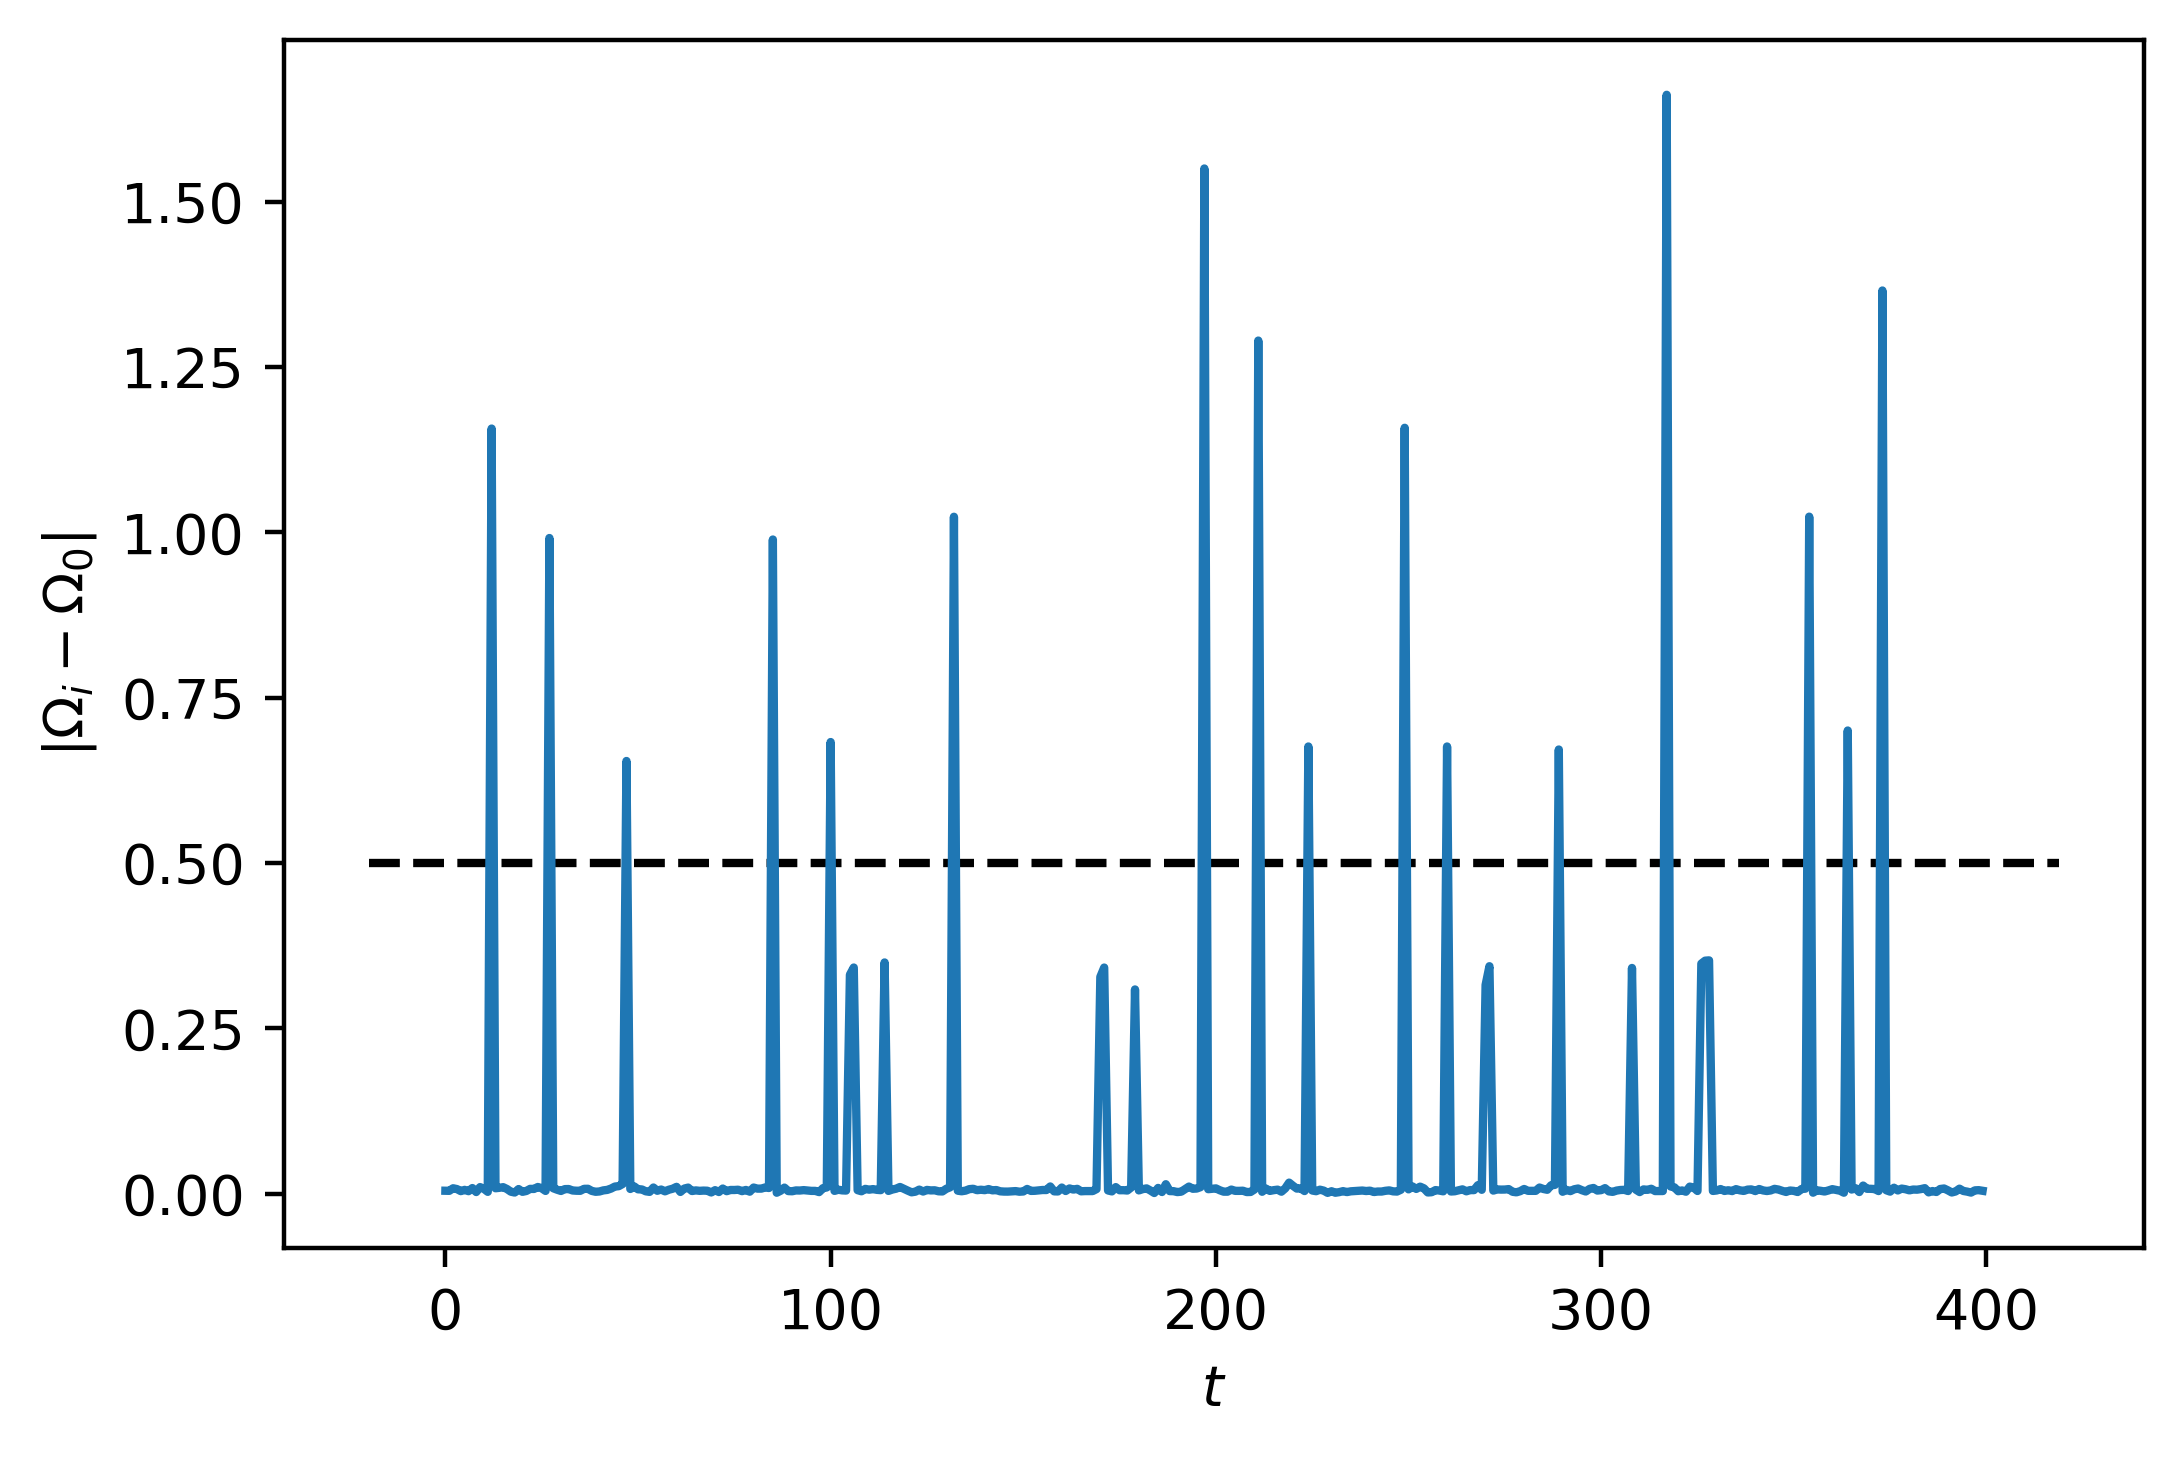

In [117]:
plt.figure(dpi=200)
plt.plot(conf_dists)
plt.hlines(0.5, *plt.xlim(), color="k", linestyle="--")
plt.ylabel(r"$|\Omega_i - \Omega_0|$")
plt.xlabel(r"$t$")

Text(0.5, 0, '$t$')

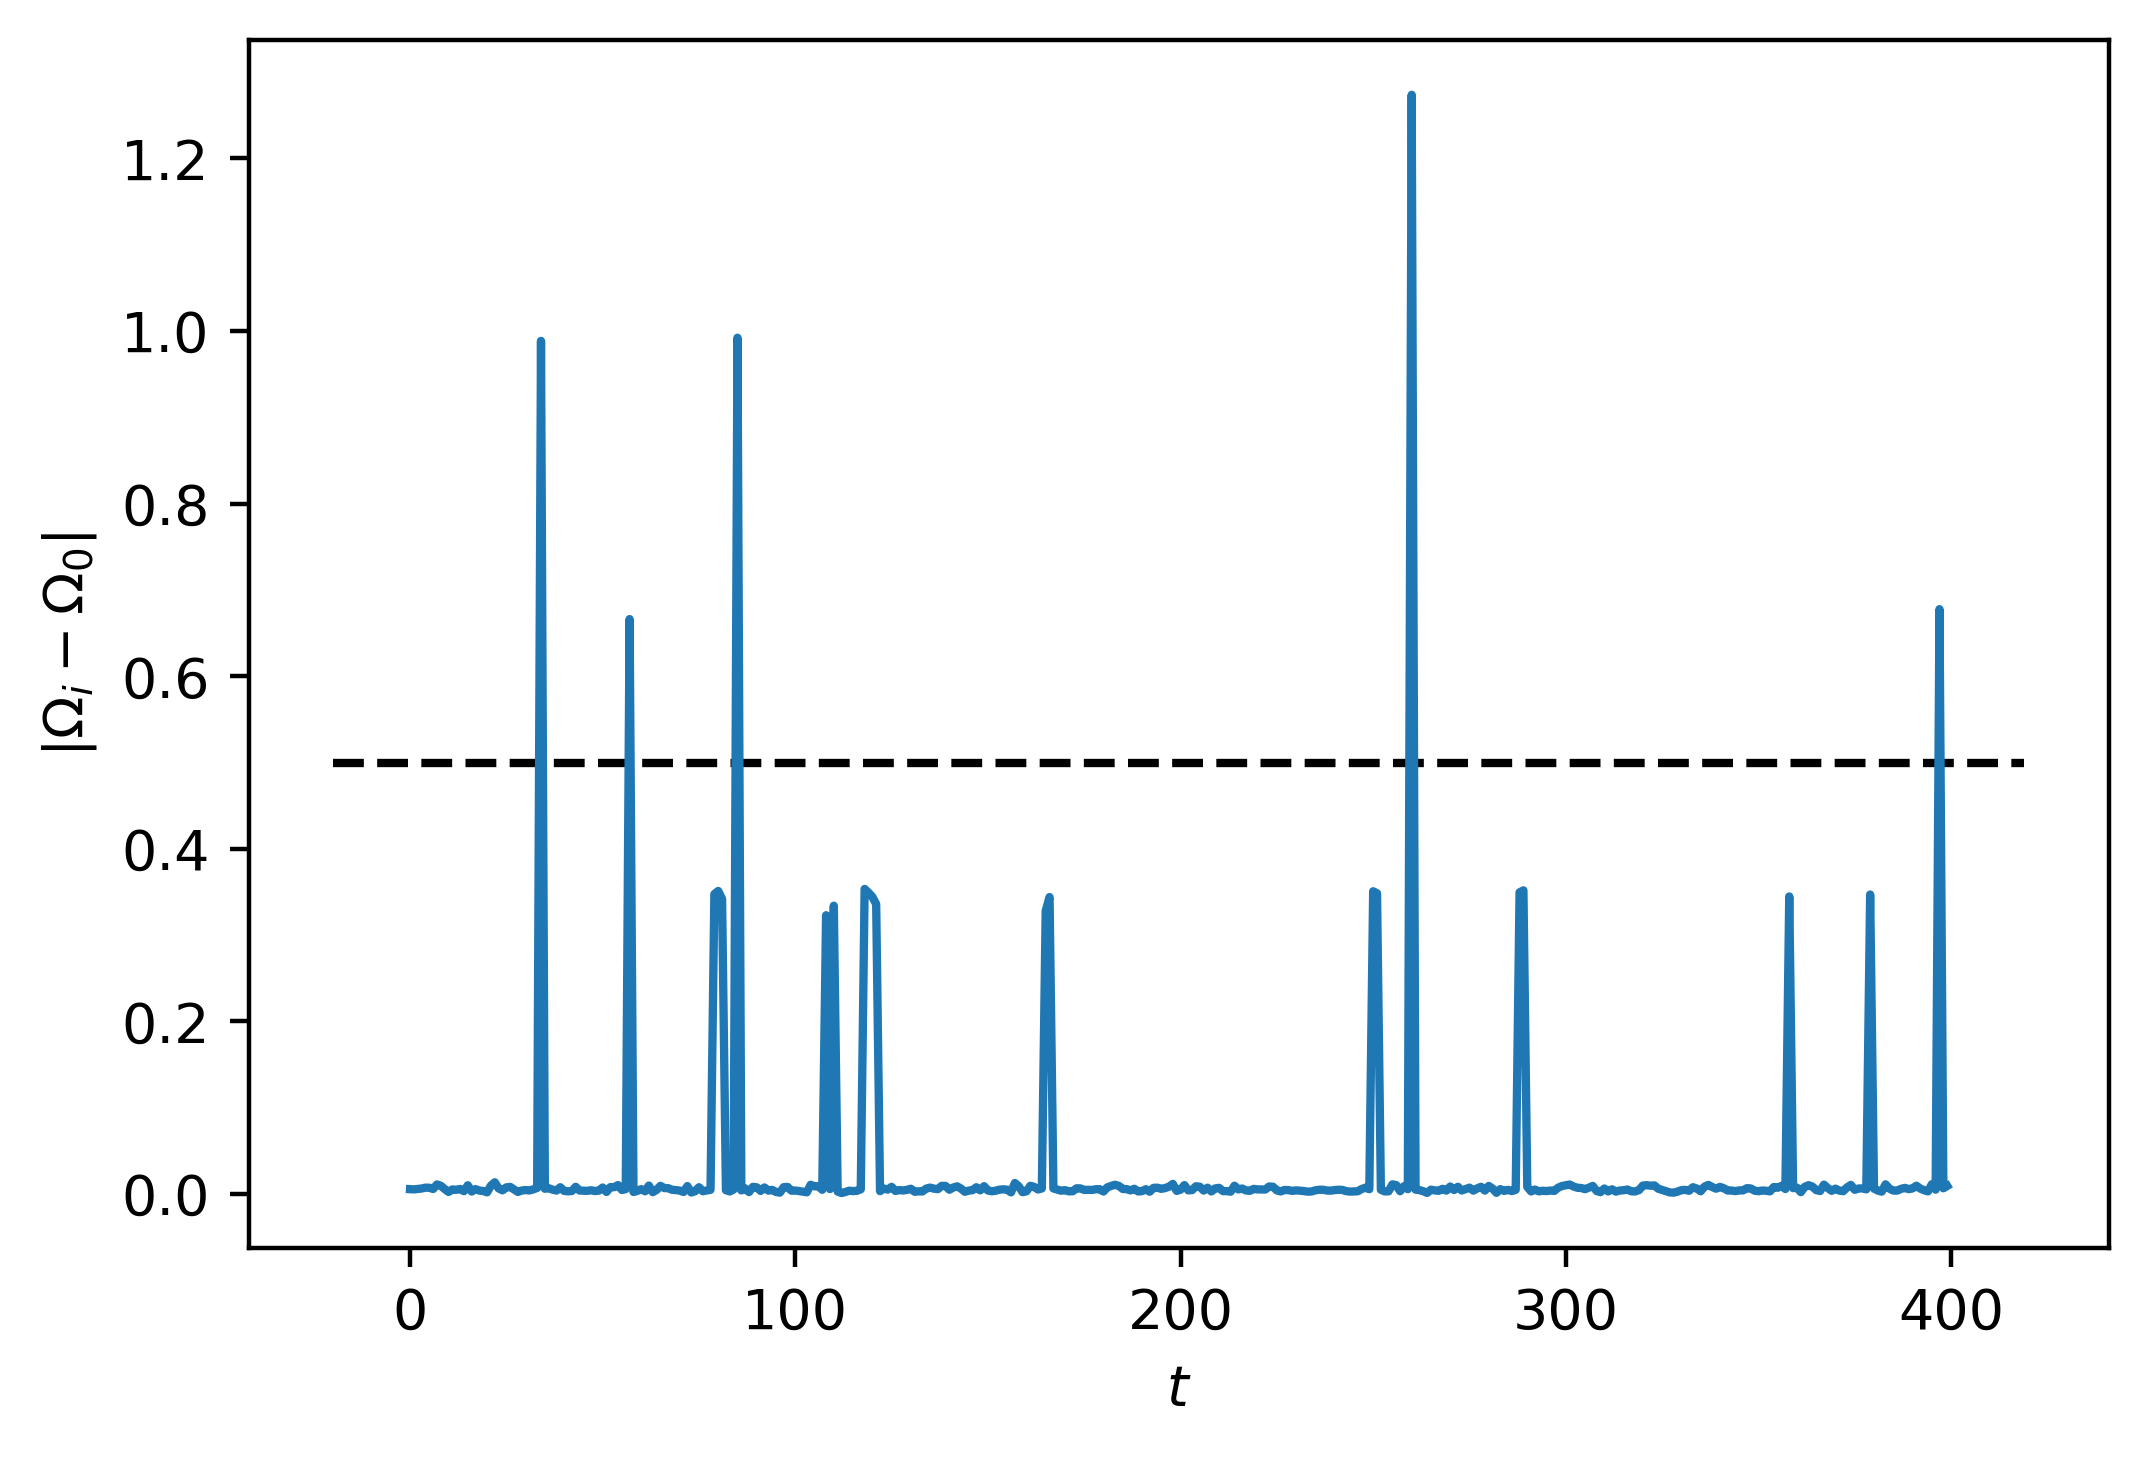

In [76]:
plt.figure(dpi=200)
plt.plot(conf_dists)
plt.hlines(0.5, *plt.xlim(), color="k", linestyle="--")
plt.ylabel(r"$|\Omega_i - \Omega_0|$")
plt.xlabel(r"$t$")

Text(0.5, 0, '$t$')

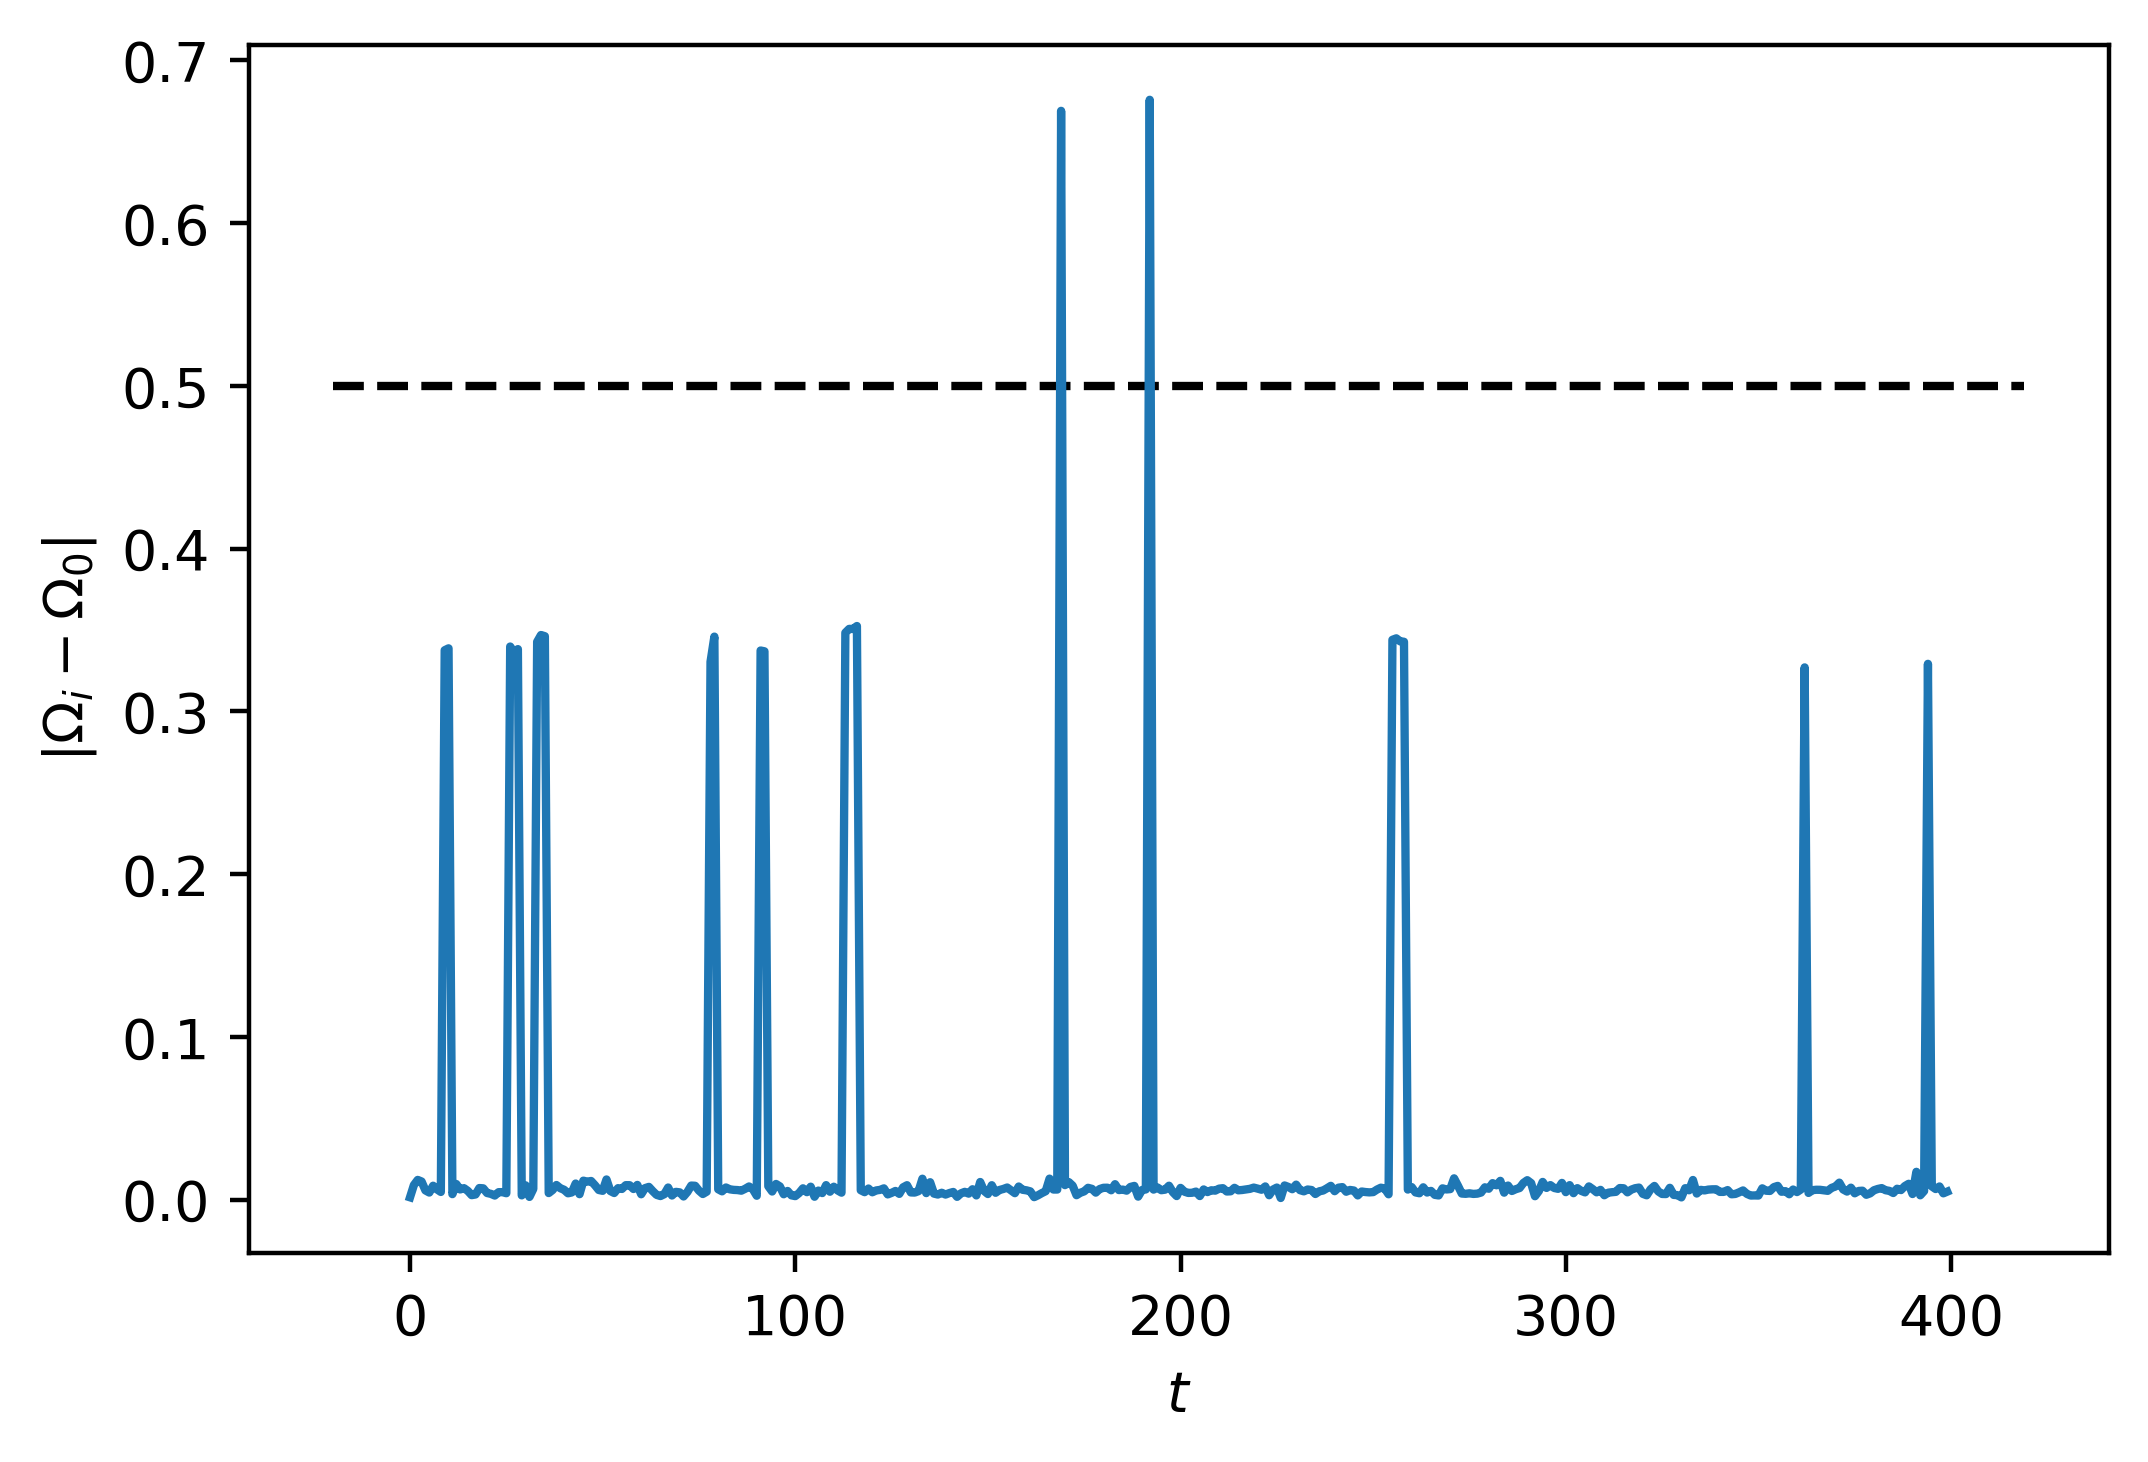

In [109]:
plt.figure(dpi=200)
plt.plot(conf_dists)
plt.hlines(0.5, *plt.xlim(), color="k", linestyle="--")
plt.ylabel(r"$|\Omega_i - \Omega_0|$")
plt.xlabel(r"$t$")

In [111]:
basin_ops[0][0]

[2.7780119905380163,
 1.120806003252503,
 2.548464958076368,
 1.723151649649687,
 2.789051240755286,
 1.2986988632486383,
 3.322339155686011,
 2.971286035411629,
 1.7808766573903816,
 4.3752043241569805,
 1.708717714821851,
 3.429678577029597,
 3.3239657270553127,
 2.824764071076687,
 1.7259959294038898,
 2.7000199983670212,
 1.7332269365505137,
 2.5396012498622897,
 3.5532881594734196,
 3.018517576434272,
 2.767732883198221,
 4.247987441278163,
 1.4009847811733096,
 1.4223940218635553,
 2.680670635421609,
 4.374508172584198,
 2.3919686038476726,
 3.2854886174656275,
 1.8195134030821534,
 3.6910857572664955,
 4.24927477818943,
 3.1870213174619195,
 3.7287542345395916,
 4.311830598530184,
 0.006882550562861679,
 2.8548613286784033,
 2.5650286951680896,
 4.218523088062686,
 3.251321077885722,
 3.687552020081002,
 3.0436322694636115,
 3.8713143872044435,
 4.473444839427123,
 0.8534360805297039,
 3.1652249787842153,
 1.875896336734258,
 3.2961635654734476,
 0.9983117341189595,
 4.400087987

In [112]:
sim.state.box

hoomd.box.Box(Lx=7.302967548370361, Ly=7.302967548370361, Lz=0.0, xy=0.0, xz=0.0, yz=0.0)

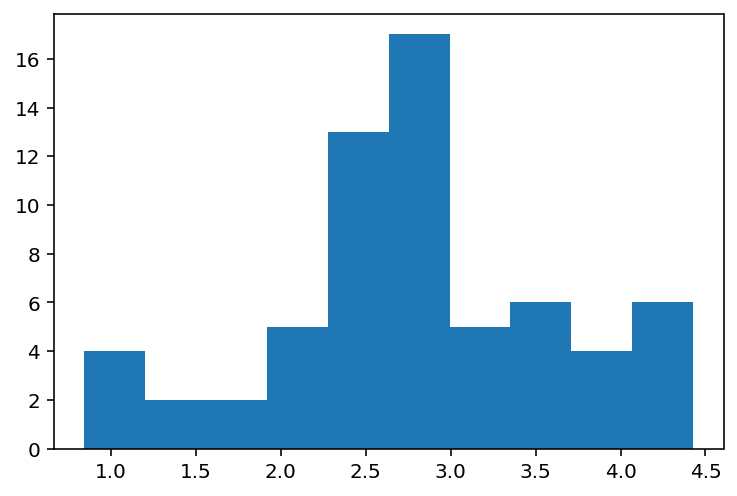

In [110]:
plt.hist(basin_ops[2][0]);